In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import pandas

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

sans_models = ['core_shell_cylinder', 'core_shell_ellipsoid', 'three_pearl_necklace', 'lamellar']
data_x_pandas = []
data_y_pandas = []
ydim=[]
for sansmodel in sans_models:
    print(sansmodel)
    data_x_pandas.append(fnLoadObject('train_'+sansmodel+'_x.dat'))
    data_y_pandas.append(fnLoadObject('train_'+sansmodel+'_y.dat'))
    # number of parameters knowing that scale and sld_solvent will be dropped
    ydim.append(data_y_pandas[-1][0].shape[0]-2)


2023-03-24 19:59:11.036378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


core_shell_cylinder
core_shell_ellipsoid
three_pearl_necklace
lamellar


In [2]:
def plot(data):
    fig, ax = plt.subplots()

    ax.errorbar(data['Q'], data['I'], data['dI'], ls='none', color='deepskyblue')
    ax.scatter(data['Q'], data['I'], s=30, marker='o', facecolors='none', edgecolors='deepskyblue', label='sim')

    ax.legend(fontsize=16)
    ax.set_ylabel("I (1/cm)", fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", labelsize=16)
    ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
    ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
    ax.figure.set_size_inches(8, 5)
    #ax.set_ylim(1e-2, .1)
    plt.tight_layout()
    plt.show()


def predict(filename, ml_model, background=0):
    print(filename)
    print("")

    data = pandas.read_csv(filename, skiprows=1, names=['Q', 'I', 'dI', 'dQ', 'c1', 'c2'], delimiter='\s+')
    print(data)
    plot(data)

    qmin = 0.01
    qmax = 0.8
    numpoints = int((numpy.log10(qmax) - numpy.log10(qmin)) * 60)
    qvec = numpy.logspace(numpy.log10(qmin), numpy.log10(qmax), num=numpoints, endpoint=True)
    qvec = qvec[:105]

    qvec_data = data['Q'].to_numpy()
    intensity_data = data['I'].to_numpy()
    intensity_data -= background
    intensity_data = numpy.log10(numpy.abs(intensity_data))

    intensity = numpy.interp(qvec, qvec_data, intensity_data)
    intensity = intensity[numpy.newaxis, :]
    intensity = tf.convert_to_tensor(intensity, dtype=tf.float32)

    y_pred = ml_model.predict(intensity)

    print("")
    print("---Classification---")
    for i, model in enumerate(sans_models):
        print(model, f'{y_pred[-1][0][i]:.2f}')
    print("")

    print("---Regression---")
    for i in range(len(y_pred)-1):
        print("Model: ", sans_models[i])
        skipcount = 0
        for j in range(ydim[i]+2):
            if data_y_pandas[i][0]['par'].iloc[j] != 'scale' and data_y_pandas[i][0]['par'].iloc[j] != 'sld_solvent':
                print(data_y_pandas[i][0]['par'].iloc[j], y_pred[i][0][j-skipcount])
            else:
                skipcount += 1
        print("")




In [3]:
# Load model for prediction. Compile = False avoids supplying the custom loss function.
ml_model = tf.keras.models.load_model('ml_model', compile=False)

5LysNaCl.sub

            Q         I        dI        dQ        c1        c2
0    0.003361  0.638534  0.080910  0.001038  0.004201  0.000503
1    0.003756  0.394159  0.060022  0.001040  0.004241  0.091110
2    0.004151  0.312985  0.048316  0.001048  0.004362  0.732700
3    0.004547  0.185027  0.043140  0.001060  0.004663  0.995000
4    0.004942  0.169852  0.035228  0.001064  0.005047  1.000000
..        ...       ...       ...       ...       ...       ...
247  0.552400  0.000655  0.001151  0.031090  0.552400  1.000000
248  0.556000 -0.001455  0.001021  0.031280  0.556000  1.000000
249  0.559500  0.001144  0.001864  0.031470  0.559500  1.000000
250  0.563100  0.001615  0.001759  0.031670  0.563100  1.000000
251  0.566600 -0.002736  0.001964  0.031860  0.566600  1.000000

[252 rows x 6 columns]


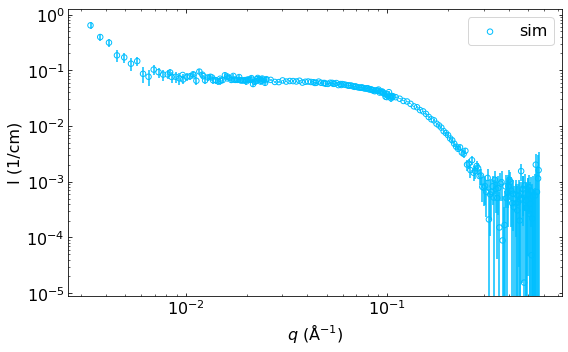

1/1 [==============================] - 0s 284ms/step

---Classification---
core_shell_cylinder 0.01
core_shell_ellipsoid 0.00
three_pearl_necklace 0.99
lamellar 0.00

---Regression---
Model:  core_shell_cylinder
length 145.1094
radius 23.816936
sld_core 0.5609312
sld_shell 0.6527104
thickness 38.025738

Model:  core_shell_ellipsoid
radius_equat_core 35.229168
sld_core -0.11899108
sld_shell -0.12505123
thick_shell 37.791283
x_core 6.1097827
x_polar_shell 5.49535

Model:  three_pearl_necklace
edge_sep 589.3435
radius 26.24965
sld -0.2587431
sld_string -0.4162078
thick_string 10.650367

Model:  lamellar
sld 5.518851
thickness 29.978119



In [4]:
predict('validation_exps/5LysNaCl.sub', ml_model)

DMPC_D2O.ABS

            Q          I         dI        dQ        c1  c2
0    0.001418  217.90000  14.620000  0.000233  0.001436   1
1    0.001676  227.90000  12.000000  0.000236  0.001691   1
2    0.001934  222.10000  10.500000  0.000240  0.001947   1
3    0.002192  224.60000  10.280000  0.000245  0.002203   1
4    0.002450  225.00000  10.860000  0.000250  0.002460   1
..        ...        ...        ...       ...       ...  ..
221  0.481500    0.06010   0.001253  0.023250  0.481500   1
222  0.485600    0.06372   0.001201  0.023440  0.485700   1
223  0.489700    0.06496   0.001205  0.023620  0.489800   1
224  0.493800    0.06432   0.001262  0.023810  0.493900   1
225  0.497900    0.06209   0.001326  0.023990  0.497900   1

[226 rows x 6 columns]


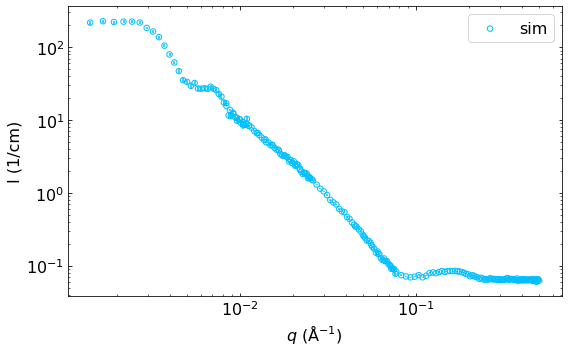

1/1 [==============================] - 0s 17ms/step

---Classification---
core_shell_cylinder 0.04
core_shell_ellipsoid 0.34
three_pearl_necklace 0.25
lamellar 0.37

---Regression---
Model:  core_shell_cylinder
length 147.02325
radius 32.44205
sld_core 1.3391576
sld_shell 1.3162651
thickness 138.82803

Model:  core_shell_ellipsoid
radius_equat_core 88.86591
sld_core 0.4175914
sld_shell -0.09203896
thick_shell 142.28435
x_core 4.5897646
x_polar_shell 6.6304345

Model:  three_pearl_necklace
edge_sep 488.4957
radius 119.438194
sld -0.14177442
sld_string -0.2520566
thick_string 10.756204

Model:  lamellar
sld 0.10339407
thickness 149.88376



In [5]:
predict('validation_exps/DMPC_D2O.ABS', ml_model, background=0.62)

validation_exps/DMPC_H2O.ABS

            Q         I         dI        dQ        c1  c2
0    0.001418  2349.000  62.740000  0.000233  0.001436   1
1    0.001676  2363.000  53.400000  0.000236  0.001691   1
2    0.001934  2409.000  62.220000  0.000240  0.001947   1
3    0.002192  2288.000  54.990000  0.000245  0.002203   1
4    0.002450  2150.000  46.670000  0.000250  0.002460   1
..        ...       ...        ...       ...       ...  ..
222  0.481500     1.089   0.008626  0.023250  0.481500   1
223  0.485600     1.091   0.006889  0.023440  0.485700   1
224  0.489700     1.082   0.008576  0.023620  0.489800   1
225  0.493800     1.094   0.007891  0.023810  0.493900   1
226  0.497900     1.094   0.007157  0.023990  0.497900   1

[227 rows x 6 columns]


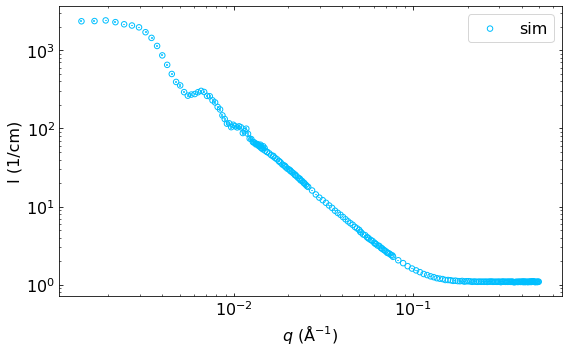

1/1 [==============================] - 0s 21ms/step

---Classification---
core_shell_cylinder 0.01
core_shell_ellipsoid 0.01
three_pearl_necklace 0.00
lamellar 0.99

---Regression---
Model:  core_shell_cylinder
length 22.449785
radius 165.57323
sld_core -0.36487758
sld_shell 0.20665294
thickness 48.953674

Model:  core_shell_ellipsoid
radius_equat_core 104.760574
sld_core -0.30568248
sld_shell 0.050995737
thick_shell 18.510101
x_core 5.2937136
x_polar_shell 6.613093

Model:  three_pearl_necklace
edge_sep 254.15659
radius 31.850563
sld 0.09658839
sld_string -0.9054198
thick_string 14.016006

Model:  lamellar
sld -3.5978262
thickness 24.788439



In [7]:
predict('validation_exps/DMPC_H2O.ABS', ml_model, background=1.02)

validation_exps/CMSA5.ABS

            Q        I        dI        dQ        c1      c2
0    0.003069  1.77100  0.250500  0.001078  0.003434  0.4038
1    0.003478  2.27700  0.190100  0.001089  0.003655  0.9565
2    0.003888  2.89100  0.142700  0.001093  0.004030  0.9999
3    0.004297  2.76200  0.114100  0.001095  0.004425  1.0000
4    0.004706  2.56000  0.089910  0.001097  0.004823  1.0000
..        ...      ...       ...       ...       ...     ...
246  0.556800  0.05061  0.001298  0.031360  0.556800  1.0000
247  0.560500  0.04926  0.000943  0.031570  0.560500  1.0000
248  0.564300  0.04799  0.001374  0.031770  0.564300  1.0000
249  0.568000  0.04918  0.001354  0.031970  0.568000  1.0000
250  0.571700  0.04681  0.001814  0.032170  0.571700  1.0000

[251 rows x 6 columns]


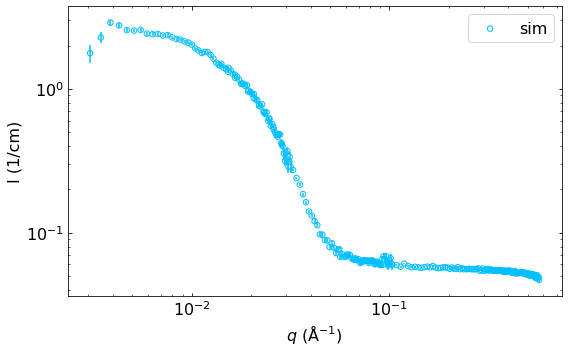

1/1 [==============================] - 0s 22ms/step

---Classification---
core_shell_cylinder 0.78
core_shell_ellipsoid 0.22
three_pearl_necklace 0.00
lamellar 0.00

---Regression---
Model:  core_shell_cylinder
length 75.11109
radius 105.41829
sld_core -0.08041984
sld_shell 0.017353535
thickness 80.65136

Model:  core_shell_ellipsoid
radius_equat_core 93.01677
sld_core 0.38068312
sld_shell -0.004304737
thick_shell 54.679832
x_core 4.3296804
x_polar_shell 6.2990837

Model:  three_pearl_necklace
edge_sep 600.4604
radius 86.567345
sld -0.28535524
sld_string 0.019144058
thick_string 11.603445

Model:  lamellar
sld -1.5778878
thickness 63.828278



In [8]:
predict('validation_exps/CMSA5.ABS', ml_model, background=0.047)